In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from IPython.display import Markdown, display
from matplotlib.lines import Line2D

import time
import tqdm
import warnings
from scipy import integrate

from scipy import stats
random_state = 999
from copy import deepcopy



## General importsÇ
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from matplotlib.colors import ListedColormap

%matplotlib inline

## SKLearn imports
from sklearn import linear_model, svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA


## AIF360 imports
from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_adult, get_distortion_german, get_distortion_compas

from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools


#SEC_ML imports
from secml.data.c_dataset import CDataset
from secml.ml.classifiers import CClassifierSVM, CClassifierLogistic
from secml.ml.kernels import CKernelRBF, CKernelLinear
from secml.ml.peval.metrics import CMetricAccuracy
from secml.data.splitter import CDataSplitterKFold

# Poisoning attacks
from secml.adv.attacks import CAttackPoisoningSVM
from secml.adv.attacks.poisoning.c_attack_poisoning_logistic_regression import CAttackPoisoningLogisticRegression

/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


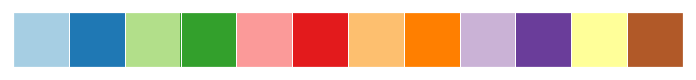

In [2]:
custom_palette=sns.diverging_palette(255, 133, l=60, n=12, center="dark")
sns.palplot(sns.color_palette("Paired", 12))
sns.set_palette(sns.color_palette("Paired"))
sns.set_style("white")
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":20,"axes.labelsize":16})

## 1. Data Generator

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # generating synthetic data
SEED = 999
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)

def generate_synthetic_data(plot_data=False, distrib_distance=np.array([5,5]), ax=None, title=""):

    """
        Code for generating the synthetic data.
        We will have two non-sensitive features and one sensitive feature.
        A sensitive feature value of 0.0 means the example is considered to be in protected group (e.g., female) and 1.0 means it's in non-protected group (e.g., male).
    """

    n_samples = 400 # generate these many data points per class
    disc_factor = math.pi / 4.0 # this variable determines the initial discrimination in the data -- decraese it to generate more discrimination

    def gen_gaussian(mean_in, cov_in, class_label):
        nv = multivariate_normal(mean = mean_in, cov = cov_in)
        X = nv.rvs(n_samples)
        y = np.ones(n_samples, dtype=float) * class_label
        return nv,X,y

    """ Generate the non-sensitive features randomly """
    # We will generate one gaussian cluster for each class
    mu1, sigma1 = np.array([2, 2]), [[5, 1], [1, 5]]
    mu2, sigma2 = np.array(mu1-distrib_distance), [[10, 1], [1, 3]]
    nv1, X1, y1 = gen_gaussian(mu1, sigma1, 1) # positive class
    nv2, X2, y2 = gen_gaussian(mu2, sigma2, 0) # negative class

    # join the posisitve and negative class clusters
    X = np.vstack((X1, X2))
    y = np.hstack((y1, y2))

    # shuffle the data
    perm = list(range(0,n_samples*2))
    shuffle(perm)
    X = X[perm]
    y = y[perm]
    
    rotation_mult = np.array([[math.cos(disc_factor), -math.sin(disc_factor)], [math.sin(disc_factor), math.cos(disc_factor)]])
    X_aux = np.dot(X, rotation_mult)


    """ Generate the sensitive feature here """
    x_control = [] # this array holds the sensitive feature value
    for i in range (0, len(X)):
        x = X_aux[i]

        # probability for each cluster that the point belongs to it
        p1 = nv1.pdf(x)
        p2 = nv2.pdf(x)
        
        # normalize the probabilities from 0 to 1
        s = p1+p2
        p1 = p1/s
        p2 = p2/s
        
        r = np.random.uniform() # generate a random number from 0 to 1

        if r < p1: # the first cluster is the positive class
            x_control.append(1.0) # 1.0 means its male
        else:
            x_control.append(0.0) # 0.0 -> female

    x_control = np.array(x_control)

    """ Show the data """
    if plot_data:
        num_to_draw = 200 # we will only draw a small number of points to avoid clutter
        x_draw = X[:num_to_draw]
        y_draw = y[:num_to_draw]
        x_control_draw = x_control[:num_to_draw]

        X_s_0 = x_draw[x_control_draw == 0.0]
        X_s_1 = x_draw[x_control_draw == 1.0]
        y_s_0 = y_draw[x_control_draw == 0.0]
        y_s_1 = y_draw[x_control_draw == 1.0]
        
        
        if ax is not None:
            ax.scatter(X_s_0[y_s_0==1.0][:, 0], X_s_0[y_s_0==1.0][:, 1], color='green', marker='x', s=30, linewidth=1.5, label= "Unprivileged favorable")
            ax.scatter(X_s_0[y_s_0==0.0][:, 0], X_s_0[y_s_0==0.0][:, 1], color='red', marker='x', s=30, linewidth=1.5, label = "Unprivileged unfavorable")
            ax.scatter(X_s_1[y_s_1==1.0][:, 0], X_s_1[y_s_1==1.0][:, 1], color='green', marker='o', facecolors='none', s=30, label = "Privileged favorable")
            ax.scatter(X_s_1[y_s_1==0.0][:, 0], X_s_1[y_s_1==0.0][:, 1], color='red', marker='o', facecolors='none', s=30, label = "Privileged unfavorable")


            ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') # dont need the ticks to see the data distribution
            ax.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
            #plt.legend(loc=2, fontsize=15)
            ax.set_title(title)
            
            #plt.xlim((-15,10))
            #plt.ylim((-10,15))
            #plt.savefig("img/data.png")
            #plt.show()
        else:
            plt.scatter(X_s_0[y_s_0==1.0][:, 0], X_s_0[y_s_0==1.0][:, 1], color='green', marker='x', s=30, linewidth=1.5, label= "Unprivileged favorable")
            plt.scatter(X_s_0[y_s_0==0.0][:, 0], X_s_0[y_s_0==0.0][:, 1], color='red', marker='x', s=30, linewidth=1.5, label = "Unprivileged unfavorable")
            plt.scatter(X_s_1[y_s_1==1.0][:, 0], X_s_1[y_s_1==1.0][:, 1], color='green', marker='o', facecolors='none', s=30, label = "Privileged favorable")
            plt.scatter(X_s_1[y_s_1==0.0][:, 0], X_s_1[y_s_1==0.0][:, 1], color='red', marker='o', facecolors='none', s=30, label = "Privileged unfavorable")


            plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') # dont need the ticks to see the data distribution
            plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
            #plt.legend(loc=2, fontsize=15)

            plt.legend(bbox_to_anchor=(1.01, 1.05),fontsize=15)
            #plt.xlim((-15,10))
            #plt.ylim((-10,15))
            #plt.savefig("img/data.png")
            plt.show()

    x_control = {"s1": x_control} # all the sensitive features are stored in a dictionary
    return X,y,x_control

## 2. Creating custom Weighted CLoss to solve the optimization

In [4]:

from secml.ml.classifiers.loss import CLossClassification, CLossLogistic
from secml.array import CArray

In [5]:
class CLossDisparateImpact(CLossClassification):
    """Surrogate function of disparate impact.

    Attributes
    ----------
    class_type : 'log'
    suitable_for : 'classification'

    """
    __class_type = 'dimp_log'

    def __init__(self, _privileged_condition):
        self._privileged_condition = CArray(_privileged_condition)

    def unprivileged(self):
        """Give 1 to unprivileged, 0 to privileged"""
        y = CArray.zeros(self._privileged_condition.size)
        y[self._privileged_condition == 0] = 1
        return y

    def loss(self, y_true, score, pos_label=1):
        """Computes loss_priv-loss_unpriv, which is what we aim to max"""
        # give 1 to unpriv, 0 to priv
        y = self.unprivileged()
        p_priv = (y == 0).sum() / y.size
        p_unpriv = (y == 1).sum() / y.size
        # loss = (score >= 0) != y  # zero-one loss
        loss = CLossLogistic().loss(y_true=y, score=score)  # smoothed version
        loss[y == 1] *= -p_priv / p_unpriv  # rebalance class weights
        return loss

    def dloss(self, y_true, score, pos_label=1):
        """Computes the derivative of the loss vs score."""
        y = self.unprivileged()
        p_priv = (y == 0).sum() / y.size
        p_unpriv = (y == 1).sum() / y.size
        grad = CLossLogistic().dloss(y, score, pos_label)
        grad[y == 1] *= -p_priv / p_unpriv  # rebalance class weights
        return grad

## 3. Helper functions

In [6]:
def calculate_disparate_impact(y,sensible_att_vals, privileged_classes=1, favorable_output=1, verbose=True):
    
    privileged = y[sensible_att_vals == privileged_classes]
    unprivileged = y[sensible_att_vals != privileged_classes]
    
    unprivileged_favorable = unprivileged[unprivileged==favorable_output]
    privileged_favorable = privileged[privileged==favorable_output]
    
    n1 =  (len(unprivileged_favorable)/ len(unprivileged))
    n2 = (len(privileged_favorable)/ len(privileged))
    disparate_impact = n1 - n2#/ (max(n2,0.0001)) 
    
    if verbose:
        print("\tUnprivileged favorable1: ", n1)
        print("\tPrivileged favorable2: ", n2)
        print("DIMP: ", disparate_impact)
     
    
    return disparate_impact

def calculate_error_rate_ratio(y_true, y_pred,sensible_att_vals, privileged_classes=1, favorable_output=1, verbose=True):
    privileged_y_true = y_true[sensible_att_vals == privileged_classes]
    unprivileged_y_true = y_true[sensible_att_vals != privileged_classes]
    
    privileged_y_pred = y_pred[sensible_att_vals == privileged_classes]
    unprivileged_y_pred = y_pred[sensible_att_vals != privileged_classes]
    
    privileged_num_errors = len(privileged_y_true) - (len(np.where(np.isclose(privileged_y_true, privileged_y_pred))[0]))
    unprivileged_num_errors = len(unprivileged_y_true) - (len(np.where(np.isclose(unprivileged_y_true, unprivileged_y_pred))[0]))
    
    if verbose:
        print("\tN1: ", n1)
        print("\tN2: ", n2)
        
    
        
    error_rate = (unprivileged_num_errors / len(unprivileged_y_true)) / (privileged_num_errors / len(privileged_y_true))
    return error_rate
    
#12[(𝐹𝑃𝑅𝐷=unprivileged−𝐹𝑃𝑅𝐷=privileged)+(𝑇𝑃𝑅𝐷=unprivileged−𝑇𝑃𝑅𝐷=privileged))]
def get_average_odds_difference(y_true, y_pred, sensible_att_vals, privileged_classes=1, favorable_output=1):
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)    

    sensible_att_vals = np.array(sensible_att_vals)
                                 
    privileged_y_true = y_true[sensible_att_vals == privileged_classes]
    unprivileged_y_true = y_true[sensible_att_vals != privileged_classes]
    
    privileged_y_pred = y_pred[sensible_att_vals == privileged_classes]
    unprivileged_y_pred = y_pred[sensible_att_vals != privileged_classes]
                                 
                                 
    FPR_unprivileged = get_false_positive_rate(unprivileged_y_true, unprivileged_y_pred, favorable_output)
    FPR_privileged = get_false_positive_rate(privileged_y_true, privileged_y_pred, favorable_output)
    TPR_unprivileged = get_true_positive_rate(unprivileged_y_true, unprivileged_y_pred, favorable_output)
    TPR_privileged = get_true_positive_rate(privileged_y_true, privileged_y_pred, favorable_output)
                              
    return 0.5 * ((FPR_unprivileged - FPR_privileged) + (TPR_unprivileged - TPR_privileged))
    
    
    

def get_false_positive_rate(y_true, y_pred, favorable_output):
    _tmp1 = y_pred[y_true!=favorable_output]
    fp = _tmp1[_tmp1 == favorable_output]
    
    N = len(y_true[y_true != favorable_output])
    
    if N == 0:
        return 0
    
    return len(fp) / N

def get_true_positive_rate(y_true, y_pred, favorable_output):
    _tmp1 = y_pred[y_true==favorable_output]
    fp = _tmp1[_tmp1 == favorable_output]
    
    P = len(y_true[y_true == favorable_output])
    
    if N == 0:
        return 0
    
    return len(fp) / P
    
    
def get_false_negative_rate(y_true, y_pred, favorable_output):
    _tmp = y_pred[y_true==favorable_output]
    
    fn = _tmp[_tmp != favorable_output]
    
    if len(_tmp) == 0:
        return 0
    
    return len(fn) / len(_tmp)

def get_error_rates(y_true, y_pred, sensible_att_vals, privileged_classes=1, favorable_output=1, verbose=False):
    privileged_y_true = y_true[sensible_att_vals == privileged_classes]
    unprivileged_y_true = y_true[sensible_att_vals != privileged_classes]
    
    privileged_y_pred = y_pred[sensible_att_vals == privileged_classes]
    unprivileged_y_pred = y_pred[sensible_att_vals != privileged_classes]
    """
    privileged_num_errors = len(privileged_y_true) - (len(np.where(np.isclose(privileged_y_true, privileged_y_pred))[0]))
    unprivileged_num_errors = len(unprivileged_y_true) - (len(np.where(np.isclose(unprivileged_y_true, unprivileged_y_pred))[0]))
    
    if verbose:
        print("\tN1: ", n1)
        print("\tN2: ", n2)

        error_rate = (unprivileged_num_errors / len(unprivileged_y_true)) / (privileged_num_errors / len(privileged_y_true))
    """
    
    FNR_privileged = get_false_negative_rate(privileged_y_true, privileged_y_pred, favorable_output)
    FNR_unprivileged = get_false_negative_rate(unprivileged_y_true, unprivileged_y_pred, favorable_output)
    
    FPR_privileged = get_false_positive_rate(privileged_y_true, privileged_y_pred, favorable_output)
    FPR_unprivileged = get_false_positive_rate(unprivileged_y_true, unprivileged_y_pred, favorable_output)
    
    
    if verbose:
        print("\tFNR_1: ", FNR_privileged)
        print("\tFNR_2: ", FNR_unprivileged)
        print("\tFPR_1: ", FPR_privileged)
        print("\tFPR_2: ", FPR_unprivileged)
    
    FNR = -1
    FPR = -1
    
    try:
        FNR = FNR_unprivileged / FNR_privileged
    except:
        pass
    
    try:
        FPR = FPR_unprivileged / FPR_privileged
    except:
        pass
        

    return ({"FNR": FNR, "FNR_privileged":FNR_privileged, "FNR_unprivileged":FNR_unprivileged, "FNR": 1}, {"FPR":FPR, "FPR_privileged":FPR_privileged, "FPR_unprivileged":FPR_unprivileged})



def train_LogReg(training_set, test_set):

    
    # Metric to use for training and performance evaluation
    # Creation of the multiclass classifier
    metric = CMetricAccuracy()

    #clf = CClassifierSVM(kernel=CKernelRBF()) # Radial Basis Function (RBF) kernel.
    #clf = CClassifierSVM(kernel=CKernelLinear()) # Linear kernel.
    clf = CClassifierLogistic()
    # Parameters for the Cross-Validation procedure
    xval_params = {'C': [1, 10]}#, 'kernel.gamma': [0.1]}#, 5, 10, 25, 50, 100]}

    # Let's create a 3-Fold data splitter
    
    xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

    # Select and set the best training parameters for the classifier
    print("Estimating the best training parameters...")
    best_params = clf.estimate_parameters(
        dataset=training_set,
        parameters=xval_params,
        splitter=xval_splitter,
        metric='accuracy',
        perf_evaluator='xval'
    )

    print("The best training parameters are: ", best_params)

    # We can now fit the classifier
    clf.fit(training_set)
    print("Training of classifier complete!")

    # Compute predictions on a test set
    y_pred = clf.predict(test_set.X)

    # Evaluate the accuracy of the classifier
    acc = metric.performance_score(y_true=test_set.Y, y_pred=y_pred)

    print("Accuracy on test set: {:.2%}".format(acc))
    
    return clf, acc

def train_SVM(training_set, test_set):

    
    # Metric to use for training and performance evaluation
    # Creation of the multiclass classifier
    metric = CMetricAccuracy()

    #clf = CClassifierSVM(kernel=CKernelRBF()) # Radial Basis Function (RBF) kernel.
    clf = CClassifierSVM(kernel=CKernelLinear()) # Linear kernel.
    #clf = CClassifierLogistic()
    # Parameters for the Cross-Validation procedure
    xval_params = {'C': [1, 10]}#,'kernel.gamma': [0.1, 5, 10, 25, 50, 100]}

    # Let's create a 3-Fold data splitter
    
    xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

    # Select and set the best training parameters for the classifier
    print("Estimating the best training parameters...")
    best_params = clf.estimate_parameters(
        dataset=training_set,
        parameters=xval_params,
        splitter=xval_splitter,
        metric='accuracy',
        perf_evaluator='xval'
    )

    print("The best training parameters are: ", best_params)

    # We can now fit the classifier
    clf.fit(training_set)
    print("Training of classifier complete!")

    # Compute predictions on a test set
    y_pred = clf.predict(test_set.X)

    # Evaluate the accuracy of the classifier
    acc = metric.performance_score(y_true=test_set.Y, y_pred=y_pred)

    print("Accuracy on test set: {:.2%}".format(acc))
    
    return clf, acc
    

In [7]:
def execute_adversarial_attack(surrogate_clf, training_set, validation_set, test_set, sensible_att_in_test, privileged_condition_validation, percentage_pois=0.25):

    metric = CMetricAccuracy()
    NUM_SAMPLES_TRAIN = training_set.num_samples
    n_poisoning_points = int(NUM_SAMPLES_TRAIN * percentage_pois) # Number of poisoning points to generate
    print("Creating {} poisoning samples ".format(n_poisoning_points))
    # Should be chosen depending on the optimization problem
    solver_params = {
        'eta': 0.05,
        'eta_min': 0.05,
        'eta_max': None,
        'max_iter': 1000,
        'eps': 1e-6
    }


    pois_attack = CAttackPoisoningLogisticRegression(classifier=surrogate_clf,
                                      training_data=training_set,
                                      surrogate_classifier=surrogate_clf,
                                      surrogate_data=validation_set,
                                      val=validation_set,
                                      distance='l2',
                                      dmax=40,
                                      lb=validation_set.X.min(), ub=validation_set.X.max(),
                                      solver_params=solver_params,
                                      random_seed=random_state,
                                      init_type="random")

    pois_attack.n_points = n_poisoning_points
    
    dimp_loss = CLossDisparateImpact(privileged_condition_validation)
    pois_attack._attacker_loss = dimp_loss

    # Run the poisoning attack
    print("Attack started...")
    pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(test_set.X, test_set.Y)
    print("Attack complete!")

    
    pois_tr = training_set.deepcopy().append(pois_ds)  # Join the training set with the poisoning points
   
    return pois_ds, pois_tr

def execute_normal_poisoning_attack(surrogate_clf, training_set, validation_set, test_set, sensible_att_in_test, privileged_condition_validation, percentage_pois=0.25):

    metric = CMetricAccuracy()
    NUM_SAMPLES_TRAIN = training_set.num_samples
    n_poisoning_points = int(NUM_SAMPLES_TRAIN * percentage_pois) # Number of poisoning points to generate
    print("Creating {} poisoning samples ".format(n_poisoning_points))
    # Should be chosen depending on the optimization problem
    solver_params = {
        'eta': 0.05,
        'eta_min': 0.05,
        'eta_max': None,
        'max_iter': 1000,
        'eps': 1e-6
    }


    pois_attack = CAttackPoisoningLogisticRegression(classifier=surrogate_clf,
                                      training_data=training_set,
                                      surrogate_classifier=surrogate_clf,
                                      surrogate_data=validation_set,
                                      val=validation_set,
                                      distance='l2',
                                      dmax=40,
                                      lb=validation_set.X.min(), ub=validation_set.X.max(),
                                      solver_params=solver_params,
                                      random_seed=random_state,
                                      init_type="random")

    pois_attack.n_points = n_poisoning_points
    
    #dimp_loss = CLossDisparateImpact(privileged_condition_validation)
    #pois_attack._attacker_loss = dimp_loss

    # Run the poisoning attack
    print("Attack started...")
    pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(test_set.X, test_set.Y)
    print("Attack complete!")

    
    pois_tr = training_set.deepcopy().append(pois_ds)  # Join the training set with the poisoning points
   
    return pois_ds, pois_tr
    
    

In [8]:
## 4. Generate Disparate Impact scenario

In [9]:
from sklearn.model_selection import train_test_split
N=9 #Max euclidean distance between average of distributions

dimp_in_data = []
euc_distances = []
dimp_scenarios = []

RANGE = np.arange(0,10, 1) 

for n in RANGE:
    
    ## Generating data
    euc_dist = n
    i = np.sqrt((euc_dist**2)/2)
    X,y,X_control = generate_synthetic_data(False, np.array([i,i]))
    formatted_X=np.array([X[:,0], X[:,1], X_control['s1']]).T ## Concatenating X with sensible att
    
    sec_ml_dataset_all = CDataset(X, y)
    sensible_att_all = X_control['s1']
    
    euc_distances.append(n)
    dimp_in_data.append(calculate_disparate_impact(sec_ml_dataset_all.Y.get_data(), sensible_att_all)) 
    
    ## Splitting data. 
    X_train_val, X_test, y_train_val, y_test = train_test_split(formatted_X, y, test_size=0.2, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=random_state)
    
    training = CDataset(X_train[:,:2], y_train)
    training_sensible_att = X_train[:,2]
    
    validation = CDataset(X_val[:,:2], y_val)
    validation_sensible_att = X_val[:,2]
    val_lambda = np.zeros(validation.num_samples)
    
    ## Creating lambda vector
    val_lambda[np.where((validation_sensible_att==0) & (y_val==0))[0]] == 1 ## Unprivileged denied
    val_lambda[np.where((validation_sensible_att==0) & (y_val==1))[0]] == 1 ## Unprivileged granted
    val_lambda[np.where((validation_sensible_att==1) & (y_val==0))[0]] == -1 ## Privileged denied
    val_lambda[np.where((validation_sensible_att==1) & (y_val==1))[0]] == -1 ## Privileged granted
    
    test = CDataset(X_test[:,:2], y_test)
    test_sensible_att = X_test[:,2]
    
    
    ## GENERATING DATA FOR WHITE BOX ATTACK
    X2,y2,X_control2 = generate_synthetic_data(False, np.array([i,i]))
    formatted_X2=np.array([X2[:,0], X2[:,1], X_control2['s1']]).T ## Concatenating X with sensible att
    
    sec_ml_dataset_all2 = CDataset(X2, y2)
    sensible_att_all2 = X_control2['s1']
    
    ## Splitting data. 
    X_train_val2, X_test2, y_train_val2, y_test2 = train_test_split(formatted_X2, y2, test_size=0.2, random_state=random_state)
    X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train_val2, y_train_val2, test_size=0.5, random_state=random_state)
    
    training2 = CDataset(X_train2[:,:2], y_train2)
    training_sensible_att2 = X_train2[:,2]
    
    validation2 = CDataset(X_val2[:,:2], y_val2)
    validation_sensible_att2 = X_val2[:,2]
    val_lambda2 = np.zeros(validation2.num_samples)
    
    ## Creating lambda vector
    val_lambda2[np.where((validation_sensible_att2==0) & (y_val2==0))[0]] == 1 ## Unprivileged denied
    val_lambda2[np.where((validation_sensible_att2==0) & (y_val2==1))[0]] == 1 ## Unprivileged granted
    val_lambda2[np.where((validation_sensible_att2==1) & (y_val2==0))[0]] == -1 ## Privileged denied
    val_lambda2[np.where((validation_sensible_att2==1) & (y_val2==1))[0]] == -1 ## Privileged granted
    
    test2 = CDataset(X_test2[:,:2], y_test)
    test_sensible_att2 = X_test2[:,2]

    scenario = {
        "name": "Use case 4 - {}".format(n),
        "description": "Disparate impact attack. \n Euclidean distance between group averages: {}\n".format(n),
        "training": training,
        "training_sensible_att" : training_sensible_att,
        "validation" : validation,
        "validation_sensible_att" : validation_sensible_att,
        "lambda_validation" : val_lambda,
        "test": test,
        "test_sensible_att" : test_sensible_att,
        "all_data" : sec_ml_dataset_all,
        "all_sensible_att" : sensible_att_all,        
        "black_box_training": training2,
        "black_box_training_sensible_att" : training_sensible_att2,
        "black_box_validation" : validation2,
        "black_box_validation_sensible_att" : validation_sensible_att2,
        "black_box_lambda_validation" : val_lambda2,
        "black_box_test": test2,
        "black_box_test_sensible_att" : test_sensible_att2,
        "black_box_all_data" : sec_ml_dataset_all2,
        "black_box_all_sensible_att" : sensible_att_all2,
    }
    
    
    dimp_scenarios.append(scenario)

	Unprivileged favorable1:  0.47988505747126436
	Privileged favorable2:  0.5154867256637168
DIMP:  -0.03560166819245242
	Unprivileged favorable1:  0.49122807017543857
	Privileged favorable2:  0.5087281795511222
DIMP:  -0.01750010937568358
	Unprivileged favorable1:  0.5022321428571429
	Privileged favorable2:  0.4971590909090909
DIMP:  0.005073051948052021
	Unprivileged favorable1:  0.45695364238410596
	Privileged favorable2:  0.5561959654178674
DIMP:  -0.09924232303376146
	Unprivileged favorable1:  0.3978260869565217
	Privileged favorable2:  0.638235294117647
DIMP:  -0.2404092071611253
	Unprivileged favorable1:  0.3624733475479744
	Privileged favorable2:  0.6948640483383686
DIMP:  -0.3323907007903942
	Unprivileged favorable1:  0.32954545454545453
	Privileged favorable2:  0.7083333333333334
DIMP:  -0.37878787878787884
	Unprivileged favorable1:  0.27053140096618356
	Privileged favorable2:  0.7461139896373057
DIMP:  -0.47558258867112213
	Unprivileged favorable1:  0.2190721649484536
	Privile

In [ ]:
for scenario in dimp_scenarios:
    print("\n\n ==== {} ====".format(scenario['name']))
    print("    - {}\n".format(scenario['description']))
    
    ################################
    ### ORIGINAL CLF PERFORMANCE ###
    ################################
    original_model, original_acc = train_LogReg(scenario["training"], scenario["test"])
    
    orig_y_pred = original_model.predict(scenario["test"].X)
    orig_FNR, orig_FPR = get_error_rates(scenario["test"].Y.get_data(), orig_y_pred.get_data(), scenario["test_sensible_att"], 1, 1)
    print("Orig")
    orig_disparate_imp = calculate_disparate_impact(orig_y_pred.get_data(), scenario["test_sensible_att"])
    orig_odds_diff = get_average_odds_difference(scenario["test"].Y.get_data(), orig_y_pred.get_data(), scenario["test_sensible_att"])

    scenario['original_classifier'] = original_model
    scenario['original_acc'] = original_acc
    scenario['orig_d_imp'] = orig_disparate_imp
    scenario['orig_odds'] = orig_odds_diff
    scenario['orig_FNR'] = orig_FNR
    scenario['orig_FPR'] = orig_FPR
    

    ########################
    ### WHITE BOX ATTACK ###
    ########################
    white_pois_clf = deepcopy(original_model)
    
    privileged_condition_valid = np.ones(scenario['validation'].num_samples)
    privileged_condition_valid[scenario["validation_sensible_att"] == 0] == -1
    
    
    white_pois_points, white_pois_tr = execute_adversarial_attack(white_pois_clf, scenario["training"], scenario["validation"], scenario["test"], scenario["test_sensible_att"], scenario["validation_sensible_att"])
    ## Retraining with poisoned points
    white_pois_clf = white_pois_clf.fit(white_pois_tr)
    white_pois_y_pred = white_pois_clf.predict(scenario["test"].X)
    
    metric = CMetricAccuracy()
    white_pois_acc = metric.performance_score(scenario["test"].Y, y_pred=white_pois_y_pred)
    print("->> white")
    white_pois_disparate_imp = calculate_disparate_impact(white_pois_y_pred.get_data(), scenario["test_sensible_att"])
    white_odds_diff = get_average_odds_difference(scenario["test"].Y.get_data(), white_pois_y_pred.get_data(), scenario["test_sensible_att"])
    white_pois_FNR, white_pois_FPR = get_error_rates(scenario["test"].Y.get_data(), white_pois_y_pred.get_data(), scenario["test_sensible_att"], 1, 1)
    

    scenario['white_poisoned_classifier'] = white_pois_clf
    scenario['white_poisoned_points'] = white_pois_points
    scenario['white_pois_d_imp'] = white_pois_disparate_imp
    scenario['white_odds'] = white_odds_diff
    scenario['white_pois_y_pred'] = white_pois_y_pred
    scenario['white_pois_acc'] = white_pois_acc
    scenario['white_pois_FNR'] = white_pois_FNR
    scenario['white_pois_FPR'] = white_pois_FPR
    
    
    
    ########################
    ### BLACK BOX ATTACK ###
    ########################
    real_model, real_acc = train_SVM(scenario["training"], scenario["test"])
    
    surrogate_clf = deepcopy(original_model)
    
    black_pois_points, black_pois_tr = execute_adversarial_attack(surrogate_clf, scenario["training"], scenario["validation"], scenario["test"], scenario["test_sensible_att"], scenario["validation_sensible_att"])
    ## Retraining with poisoned points
    
    black_pois_clf = deepcopy(real_model)
    black_pois_clf = black_pois_clf.fit(black_pois_tr)
    black_pois_y_pred = black_pois_clf.predict(scenario["test"].X)
    
    black_pois_acc = metric.performance_score(y_true=scenario["test"].Y, y_pred=black_pois_y_pred)
    print("->> black")
    black_pois_disparate_imp = calculate_disparate_impact(black_pois_y_pred.get_data(), scenario["test_sensible_att"])
    black_odds_diff = get_average_odds_difference(scenario["test"].Y.get_data(), black_pois_y_pred.get_data(), scenario["test_sensible_att"])
    black_pois_FNR, black_pois_FPR = get_error_rates(scenario["test"].Y.get_data(), black_pois_y_pred.get_data(), scenario["test_sensible_att"], 1, 1)
    

    scenario['black_poisoned_classifier'] = black_pois_clf
    scenario['black_poisoned_points'] = black_pois_points
    scenario['black_pois_d_imp'] = black_pois_disparate_imp
    scenario['black_odds'] = black_odds_diff
    scenario['black_pois_y_pred'] = black_pois_y_pred
    scenario['black_pois_acc'] = black_pois_acc
    scenario['black_pois_FNR'] = black_pois_FNR
    scenario['black_pois_FPR'] = black_pois_FPR
    
    
    
    ################################
    ### CLASSIC POISONING ATTACK ###
    ################################
    normal_pois_clf = deepcopy(original_model)
    
    privileged_condition_valid = np.ones(scenario['validation'].num_samples)
    privileged_condition_valid[scenario["validation_sensible_att"] == 0] == -1
    
    
    normal_pois_points, normal_pois_tr = execute_normal_poisoning_attack(normal_pois_clf, scenario["training"], scenario["validation"], scenario["test"], scenario["test_sensible_att"], scenario["validation_sensible_att"])
    ## Retraining with poisoned points
    normal_pois_clf = normal_pois_clf.fit(normal_pois_tr)
    normal_pois_y_pred = normal_pois_clf.predict(scenario["test"].X)
    
    metric = CMetricAccuracy()
    normal_pois_acc = metric.performance_score(scenario["test"].Y, y_pred=normal_pois_y_pred)
    print("->> normal")
    normal_pois_disparate_imp = calculate_disparate_impact(normal_pois_y_pred.get_data(), scenario["test_sensible_att"])
    normal_odds_diff = get_average_odds_difference(scenario["test"].Y.get_data(), normal_pois_y_pred.get_data(), scenario["test_sensible_att"])
    normal_pois_FNR, normal_pois_FPR = get_error_rates(scenario["test"].Y.get_data(), normal_pois_y_pred.get_data(), scenario["test_sensible_att"], 1, 1)
    

    scenario['normal_poisoned_classifier'] = normal_pois_clf
    scenario['normal_poisoned_points'] = normal_pois_points
    scenario['normal_pois_d_imp'] = normal_pois_disparate_imp
    scenario['normal_odds'] = normal_odds_diff
    scenario['normal_pois_y_pred'] = normal_pois_y_pred
    scenario['normal_pois_acc'] = normal_pois_acc
    scenario['normal_pois_FNR'] = normal_pois_FNR
    scenario['normal_pois_FPR'] = normal_pois_FPR
    
    
    
    



 ==== Use case 4 - 0 ====
    - Disparate impact attack. 
 Euclidean distance between group averages: 0


Estimating the best training parameters...
The best training parameters are:  {'C': 10}
Training of classifier complete!
Accuracy on test set: 44.38%
Orig
	Unprivileged favorable1:  0.4266666666666667
	Privileged favorable2:  0.49411764705882355
DIMP:  -0.06745098039215686
Creating 80 poisoning samples 
Attack started...
Attack complete!
->> white
	Unprivileged favorable1:  0.76
	Privileged favorable2:  0.5647058823529412
DIMP:  0.19529411764705884
Estimating the best training parameters...
The best training parameters are:  {'C': 1}
Training of classifier complete!
Accuracy on test set: 45.00%
Creating 80 poisoning samples 
Attack started...


In [ ]:
from matplotlib.gridspec import GridSpec
def plot_disparate_impact(scenarios, data_dimp=None , n_scenarios=9, title=None):
    
    _x_ = [n for n in range(len(scenarios))]
    
    fig=plt.figure(figsize=[12,8])
    if title is not None:
        plt.suptitle(title, fontsize=14)

    gs=GridSpec(2,4) # 2 rows, 3 columns

    ax1=fig.add_subplot(gs[0,:2]) # Second row, span all columns
    ax1.set_title("Accuracy")
    
    ax1.plot(_x_,[float(UC["original_acc"]) for UC in scenarios], c="darkgreen", label="Original classifier.")
    ax1.plot(_x_,[float(UC["white_pois_acc"]) for UC in scenarios], c="red", label="Poisoned classifier. White box attack.")
    ax1.plot(_x_,[float(UC["black_pois_acc"]) for UC in scenarios], c="orange", label="Poisoned classifier. Black box attack.")
    ax1.plot(_x_,[float(UC["normal_pois_acc"]) for UC in scenarios], '--', c="blue", label="Error-generic poisoning attack")
    

    ax2=fig.add_subplot(gs[0,2]) # First row, first column
    ax2.set_title("Demographic parity")
    ax2.plot(_x_,[UC["orig_d_imp"] for UC in scenarios], c="darkgreen", label="Original classifier.")
    if data_dimp is not None:
        ax2.plot(_x_,data_dimp, c="darkgrey", label="Original data")
    ax2.plot(_x_,[UC["white_pois_d_imp"] for UC in scenarios], c="red", label="Poisoned classifier. White box attack.")
    ax2.plot(_x_,[UC["black_pois_d_imp"] for UC in scenarios], c="orange", label="Poisoned classifier. Black box attack.")
    ax2.plot(_x_,[UC["normal_pois_d_imp"] for UC in scenarios], '--', c="blue", label="Error-generic poisoning attack")
    
    ax2b=fig.add_subplot(gs[0,3]) # First row, first column
    ax2b.set_title("Average odds difference")
    ax2b.plot(_x_,[UC["orig_odds"] for UC in scenarios], c="darkgreen", label="Original classifier.")
    ax2b.plot(_x_,[UC["white_odds"] for UC in scenarios], c="red", label="Poisoned classifier. White box attack.")
    ax2b.plot(_x_,[UC["black_odds"] for UC in scenarios], c="orange", label="Poisoned classifier. Black box attack.")
    ax2b.plot(_x_,[UC["normal_odds"] for UC in scenarios], '--', c="blue", label="Error-generic poisoning attack")

    ax3=fig.add_subplot(gs[1,0]) # First row, second column
    ax3.set_title("FNR privileged")
    ax3.plot(_x_,[UC["orig_FNR"]["FNR_privileged"] for UC in scenarios], c="darkgreen", label="Original classifier.")
    ax3.plot(_x_,[UC["white_pois_FNR"]['FNR_privileged'] for UC in scenarios], c="red", label="Poisoned classifier. White box attack.")
    ax3.plot(_x_,[UC["black_pois_FNR"]['FNR_privileged'] for UC in scenarios], c="orange", label="Poisoned classifier. Black box attack.")
    ax3.plot(_x_,[UC["normal_pois_FNR"]['FNR_privileged'] for UC in scenarios], '--', c="blue", label="Error-generic poisoning attack")

    ax4=fig.add_subplot(gs[1,1]) # First row, third column
    ax4.set_title("FNR unprivileged")
    ax4.plot(_x_,[UC["orig_FNR"]["FNR_unprivileged"] for UC in scenarios], c="darkgreen", label="Original classifier.")
    ax4.plot(_x_,[UC["white_pois_FNR"]['FNR_unprivileged'] for UC in scenarios], c="red", label="Poisoned classifier. White box attack.")
    ax4.plot(_x_,[UC["black_pois_FNR"]['FNR_unprivileged'] for UC in scenarios], c="orange", label="Poisoned classifier. Black box attack.")
    ax4.plot(_x_,[UC["normal_pois_FNR"]['FNR_unprivileged'] for UC in scenarios], '--', c="blue", label="Error-generic poisoning attack")
    ax4.plot([], [], c="gray", label="Disparate impact in the data")
    
    ax4.legend(bbox_to_anchor=(1.8, -0.1),fontsize=15)
    
    ax5=fig.add_subplot(gs[1,2]) # First row, second column
    ax5.set_title("FPR privileged")
    ax5.plot(_x_,[UC["orig_FPR"]["FPR_privileged"] for UC in scenarios], c="darkgreen", label="Original classifier.")
    ax5.plot(_x_,[UC["white_pois_FPR"]['FPR_privileged'] for UC in scenarios], c="red", label="Poisoned classifier. White box attack.")
    ax5.plot(_x_,[UC["black_pois_FPR"]['FPR_privileged'] for UC in scenarios], c="orange", label="Poisoned classifier. Black box attack.")
    ax5.plot(_x_,[UC["normal_pois_FPR"]['FPR_privileged'] for UC in scenarios], '--', c="blue", label="Error-generic poisoning attack")

    ax6=fig.add_subplot(gs[1,3]) # First row, third column
    ax6.set_title("FPR unprivileged")
    ax6.plot(_x_,[UC["orig_FPR"]["FPR_unprivileged"] for UC in scenarios], c="darkgreen", label="Original classifier.")
    ax6.plot(_x_,[UC["white_pois_FPR"]['FPR_unprivileged'] for UC in scenarios], c="red", label="Poisoned classifier. White box attack.")
    ax6.plot(_x_,[UC["black_pois_FPR"]['FPR_unprivileged'] for UC in scenarios], c="orange", label="Poisoned classifier. Black box attack.")
    ax6.plot(_x_,[UC["normal_pois_FPR"]['FPR_unprivileged'] for UC in scenarios], '--', c="blue", label="Error-generic poisoning attack")
    
    plt.plot()


In [ ]:
plot_disparate_impact(dimp_scenarios, dimp_in_data)

In [ ]:
def plot_2d_decision_boundary_for_test(use_case):
    import warnings
    warnings.filterwarnings(action='once')
    
    clf = use_case['original_classifier']
    pois_ds = use_case['white_poisoned_points']
    
    training_set = use_case['training']
    validation_set = use_case['validation']
    test_set = use_case['test']
    
    sensible_att_train = use_case['training_sensible_att']
    sensible_att_val = use_case['validation_sensible_att']
    sensible_att_test = use_case['test_sensible_att']

    
    ## Training data
    tr_tmp_X = training_set.X.get_data()
    tr_tmp_Y = training_set.Y.get_data().ravel()

    tr1 = CDataset(tr_tmp_X[sensible_att_train == 0], tr_tmp_Y[sensible_att_train == 0])
    tr2 = CDataset(tr_tmp_X[sensible_att_train == 1], tr_tmp_Y[sensible_att_train == 1])
    
    ## Validation data
    val_tmp_X = validation_set.X.get_data()
    val_tmp_Y = validation_set.Y.get_data().ravel()

    val1 = CDataset(val_tmp_X[sensible_att_val == 0], val_tmp_Y[sensible_att_val == 0])
    val2 = CDataset(val_tmp_X[sensible_att_val == 1], val_tmp_Y[sensible_att_val == 1])
    
    ## Test data
    ts_tmp_X = test_set.X.get_data()
    ts_tmp_Y = test_set.Y.get_data().ravel()

    ts1 = CDataset(ts_tmp_X[sensible_att_test == 0], ts_tmp_Y[sensible_att_test == 0])
    ts2 = CDataset(ts_tmp_X[sensible_att_test == 1], ts_tmp_Y[sensible_att_test == 1])
    
    
    pois_clf = use_case['white_poisoned_classifier']

    
    pois_points_X = pois_ds.X.get_data()
    pois_points_Y = pois_ds.Y.get_data().ravel()
    
    pois_ds1 = CDataset(pois_points_X[pois_points_Y==1], pois_points_Y[pois_points_Y==1])
    pois_ds2 = CDataset(pois_points_X[pois_points_Y==0], pois_points_Y[pois_points_Y==0])
    
    pois_tr = deepcopy(training_set).append(pois_ds)
    
    # Define common bounds for the subplots
    min_limit = min(pois_tr.X.min(), training_set.X.min())
    max_limit = max(pois_tr.X.max(), training_set.X.max())
    grid_limits = [[min_limit, max_limit], [min_limit, max_limit]]

    from secml.figure import CFigure
    fig = CFigure(15, 10)

    fig.subplot(3, 2, 1)
    fig.sp.title("Original classifier (training set)")
    fig.sp.plot_decision_regions(
        clf, n_grid_points=200, grid_limits=grid_limits, cmap="RdYlGn")


    fig.sp.plot_ds(tr1, markersize=7, colors=['red', 'green'], markers='X')
    fig.sp.plot_ds(tr2, markersize=5, colors=['green', 'red'], markers='o')#, markerfacecolor="None", markeredgecolor='g', markeredgewidth=1.5)
    fig.sp.grid(grid_on=True)

    fig.subplot(3, 2, 2)
    fig.sp.title("Poisoned classifier (training set + poisoning points)")
    fig.sp.plot_decision_regions(
        pois_clf, n_grid_points=200, grid_limits=grid_limits, cmap="RdYlGn")
    fig.sp.plot_ds(tr1, markersize=7, colors=['red', 'green'], markers='X')
    fig.sp.plot_ds(tr2, markersize=5, colors=['green', 'red'], markers='o')
    fig.sp.plot_ds(pois_ds1, markers='*', markersize=12, colors='darkred')
    fig.sp.plot_ds(pois_ds2, markers='*', markersize=12, colors='darkgreen')
    fig.sp.grid(grid_on=True)
    

    fig.subplot(3, 2, 3)
    fig.sp.title("Original classifier (test set)")
    fig.sp.plot_decision_regions(
        clf, n_grid_points=200, grid_limits=grid_limits, cmap="RdYlGn")

    fig.sp.plot_ds(ts1, markersize=7, colors=['red', 'green'], markers='X')
    fig.sp.plot_ds(ts2, markersize=5, colors=['red', 'green'], markers='o')
    #fig.sp.text(0.05, -0.25, "Accuracy on test set: {:.2%}".format(acc),bbox=dict(facecolor='white'))
    fig.sp.grid(grid_on=True)

    fig.subplot(3, 2, 4)
    fig.sp.title("Poisoned classifier (test set)")
    fig.sp.plot_decision_regions(
        pois_clf, n_grid_points=200, grid_limits=grid_limits, cmap="RdYlGn")

    fig.sp.plot_ds(ts1, markersize=7, colors=['red', 'green'], markers='X')
    fig.sp.plot_ds(ts2, markersize=5, colors=['red', 'green'], markers='o')
    #fig.sp.text(0.05, -0.25, "Accuracy on test set: {:.2%}".format(pois_acc),bbox=dict(facecolor='white'))
    
    fig.subplot(3, 2, 5)
    fig.sp.title("Original classifier (validation set)")
    fig.sp.plot_decision_regions(
        clf, n_grid_points=200, grid_limits=grid_limits, cmap="RdYlGn")
    fig.sp.plot_ds(val1, markersize=7, colors=['red', 'green'], markers='X')
    fig.sp.plot_ds(val2, markersize=5, colors=['green', 'red'], markers='o')
    fig.sp.grid(grid_on=True)
    
    fig.subplot(3, 2, 6)
    fig.sp.title("Poisoned classifier (validation set + poisoning points)")
    fig.sp.plot_decision_regions(
        pois_clf, n_grid_points=200, grid_limits=grid_limits, cmap="RdYlGn")
    fig.sp.plot_ds(val1, markersize=7, colors=['red', 'green'], markers='X')
    fig.sp.plot_ds(val2, markersize=5, colors=['green', 'red'], markers='o')
    fig.sp.plot_ds(pois_ds1, markers='*', markersize=12, colors='darkred')
    fig.sp.plot_ds(pois_ds2, markers='*', markersize=12, colors='darkgreen')
    fig.sp.grid(grid_on=True)

    fig.sp.grid(grid_on=True)

    fig.show()

In [ ]:
plot_2d_decision_boundary_for_test(dimp_scenarios[8])

In [ ]:
def plot_2d_decision_boundary_for_test2(use_case):
    import warnings
    warnings.filterwarnings(action='once')
    
    clf = use_case['original_classifier']
    pois_ds = use_case['white_poisoned_points']
    
    training_set = use_case['training']
    validation_set = use_case['validation']
    test_set = use_case['test']
    
    sensible_att_train = use_case['training_sensible_att']
    sensible_att_val = use_case['validation_sensible_att']
    sensible_att_test = use_case['test_sensible_att']

    
    ## Training data
    tr_tmp_X = training_set.X.get_data()
    tr_tmp_Y = training_set.Y.get_data().ravel()

    tr1 = CDataset(tr_tmp_X[sensible_att_train == 0], tr_tmp_Y[sensible_att_train == 0])
    tr2 = CDataset(tr_tmp_X[sensible_att_train == 1], tr_tmp_Y[sensible_att_train == 1])
    
    ## Validation data
    val_tmp_X = validation_set.X.get_data()
    val_tmp_Y = validation_set.Y.get_data().ravel()

    val1 = CDataset(val_tmp_X[sensible_att_val == 0], val_tmp_Y[sensible_att_val == 0])
    val2 = CDataset(val_tmp_X[sensible_att_val == 1], val_tmp_Y[sensible_att_val == 1])
    
    ## Test data
    ts_tmp_X = test_set.X.get_data()
    ts_tmp_Y = test_set.Y.get_data().ravel()

    ts1 = CDataset(ts_tmp_X[sensible_att_test == 0], ts_tmp_Y[sensible_att_test == 0])
    ts2 = CDataset(ts_tmp_X[sensible_att_test == 1], ts_tmp_Y[sensible_att_test == 1])
    
    
    pois_clf = use_case['white_poisoned_classifier']

    
    pois_points_X = pois_ds.X.get_data()
    pois_points_Y = pois_ds.Y.get_data().ravel()
    
    pois_ds1 = CDataset(pois_points_X[pois_points_Y==1], pois_points_Y[pois_points_Y==1])
    pois_ds2 = CDataset(pois_points_X[pois_points_Y==0], pois_points_Y[pois_points_Y==0])
    
    pois_tr = deepcopy(training_set).append(pois_ds)
    
    # Define common bounds for the subplots
    min_limit = min(pois_tr.X.min(), training_set.X.min())
    max_limit = max(pois_tr.X.max(), training_set.X.max())
    grid_limits = [[min_limit, max_limit], [min_limit, max_limit]]

    from secml.figure import CFigure
    fig = CFigure(6, 12)

    fig.subplot(1, 2, 1)
    #fig.sp.title("Original classifier (training set)")
    fig.sp.plot_decision_regions(
        clf, n_grid_points=200, grid_limits=grid_limits, cmap="RdYlGn")


    fig.sp.plot_ds(tr1, markersize=7, colors=['red', 'green'], markers='X')
    fig.sp.plot_ds(tr2, markersize=5, colors=['green', 'red'], markers='o')#, markerfacecolor="None", markeredgecolor='g', markeredgewidth=1.5)
    fig.sp.grid(grid_on=True)

    fig.subplot(1, 2, 2)
    #fig.sp.title("Poisoned classifier (training set + poisoning points)")
    fig.sp.plot_decision_regions(
        pois_clf, n_grid_points=200, grid_limits=grid_limits, cmap="RdYlGn")
    fig.sp.plot_ds(tr1, markersize=7, colors=['red', 'green'], markers='X')
    fig.sp.plot_ds(tr2, markersize=5, colors=['green', 'red'], markers='o')
    fig.sp.plot_ds(pois_ds1, markers='*', markersize=12, colors='darkred')
    fig.sp.plot_ds(pois_ds2, markers='*', markersize=12, colors='darkgreen')
    fig.sp.grid(grid_on=True)
    plt.legend()
    fig.show()

In [ ]:
plot_2d_decision_boundary_for_test2(dimp_scenarios[8])

In [ ]:
_datasets = []
_sensible_atts = []
_formatted_Xs = []

_dimp_in_data = []
_euc_distances = []



for n in RANGE:
    ## Generating data
    euc_dist = n
    i = np.sqrt((euc_dist**2)/2)
    X,y,X_control = generate_synthetic_data(False, np.array([i,i]))
    formatted_X=np.array([X[:,0], X[:,1], X_control['s1']]).T ## Concatenating X with sensible att

    sec_ml_dataset_all = CDataset(X, y)
    
    
    sensible_att_all = X_control['s1']
    
    _datasets.append(sec_ml_dataset_all)
    _sensible_atts.append(sensible_att_all)
    _formatted_Xs.append(formatted_X)
    
    _euc_distances.append(n)
    _dimp_in_data.append(calculate_disparate_impact(sec_ml_dataset_all.Y.get_data(), sensible_att_all)) 

In [ ]:
## Multiple runs
def compare_multiple_runs(num_reps = 5):
    reps_results = []
    for i in range(num_reps):
        _count = 0
        
        
       
        _scenarios = []

        for n in RANGE:
            
            sec_ml_dataset_all = _datasets[_count]
            sensible_att_all = _sensible_atts[_count]
            formatted_X = _formatted_Xs[_count]
            
            X = sec_ml_dataset_all.X.get_data()
            y = sec_ml_dataset_all.Y.get_data()
            
            
            _count+=1
            
            
            ## Splitting data. 
            X_train_val, X_test, y_train_val, y_test = train_test_split(formatted_X, y, test_size=0.2, random_state=random_state)
            X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=random_state)

            training = CDataset(X_train[:,:2], y_train)
            training_sensible_att = X_train[:,2]

            validation = CDataset(X_val[:,:2], y_val)
            validation_sensible_att = X_val[:,2]
            val_lambda = np.zeros(validation.num_samples)

            ## Creating lambda vector
            val_lambda[np.where((validation_sensible_att==0) & (y_val==0))[0]] == 1 ## Unprivileged denied
            val_lambda[np.where((validation_sensible_att==0) & (y_val==1))[0]] == 1 ## Unprivileged granted
            val_lambda[np.where((validation_sensible_att==1) & (y_val==0))[0]] == -1 ## Privileged denied
            val_lambda[np.where((validation_sensible_att==1) & (y_val==1))[0]] == -1 ## Privileged granted

            test = CDataset(X_test[:,:2], y_test)
            test_sensible_att = X_test[:,2]


            ## GENERATING DATA FOR WHITE BOX ATTACK
            X2,y2,X_control2 = generate_synthetic_data(False, np.array([i,i]))
            formatted_X2=np.array([X2[:,0], X2[:,1], X_control2['s1']]).T ## Concatenating X with sensible att

            sec_ml_dataset_all2 = CDataset(X2, y2)
            sensible_att_all2 = X_control2['s1']

            ## Splitting data. 
            X_train_val2, X_test2, y_train_val2, y_test2 = train_test_split(formatted_X2, y2, test_size=0.2, random_state=random_state)
            X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train_val2, y_train_val2, test_size=0.5, random_state=random_state)

            training2 = CDataset(X_train2[:,:2], y_train2)
            training_sensible_att2 = X_train2[:,2]

            validation2 = CDataset(X_val2[:,:2], y_val2)
            validation_sensible_att2 = X_val2[:,2]
            val_lambda2 = np.zeros(validation2.num_samples)

            ## Creating lambda vector
            val_lambda2[np.where((validation_sensible_att2==0) & (y_val2==0))[0]] == 1 ## Unprivileged denied
            val_lambda2[np.where((validation_sensible_att2==0) & (y_val2==1))[0]] == 1 ## Unprivileged granted
            val_lambda2[np.where((validation_sensible_att2==1) & (y_val2==0))[0]] == -1 ## Privileged denied
            val_lambda2[np.where((validation_sensible_att2==1) & (y_val2==1))[0]] == -1 ## Privileged granted

            test2 = CDataset(X_test2[:,:2], y_test)
            test_sensible_att2 = X_test2[:,2]

            scenario = {
                "name": "Use case 4 - {}".format(n),
                "description": "Disparate impact attack. \n Euclidean distance between group averages: {}\n".format(n),
                "training": training,
                "training_sensible_att" : training_sensible_att,
                "validation" : validation,
                "validation_sensible_att" : validation_sensible_att,
                "lambda_validation" : val_lambda,
                "test": test,
                "test_sensible_att" : test_sensible_att,
                "all_data" : sec_ml_dataset_all,
                "all_sensible_att" : sensible_att_all,        
                "black_box_training": training2,
                "black_box_training_sensible_att" : training_sensible_att2,
                "black_box_validation" : validation2,
                "black_box_validation_sensible_att" : validation_sensible_att2,
                "black_box_lambda_validation" : val_lambda2,
                "black_box_test": test2,
                "black_box_test_sensible_att" : test_sensible_att2,
                "black_box_all_data" : sec_ml_dataset_all2,
                "black_box_all_sensible_att" : sensible_att_all2,
            }


            _scenarios.append(scenario)
    
        for scenario in _scenarios:
            print("\n\n ==== {} ====".format(scenario['name']))
            print("    - {}\n".format(scenario['description']))

            ################################
            ### ORIGINAL CLF PERFORMANCE ###
            ################################
            original_model, original_acc = train_LogReg(scenario["training"], scenario["test"])

            orig_y_pred = original_model.predict(scenario["test"].X)
            orig_FNR, orig_FPR = get_error_rates(scenario["test"].Y.get_data(), orig_y_pred.get_data(), scenario["test_sensible_att"], 1, 1)
            print("Orig")
            orig_disparate_imp = calculate_disparate_impact(orig_y_pred.get_data(), scenario["test_sensible_att"])
            orig_odds_diff = get_average_odds_difference(scenario["test"].Y.get_data(), orig_y_pred.get_data(), scenario["test_sensible_att"])

            scenario['original_classifier'] = original_model
            scenario['original_acc'] = original_acc
            scenario['orig_d_imp'] = orig_disparate_imp
            scenario['orig_odds'] = orig_odds_diff
            scenario['orig_FNR'] = orig_FNR
            scenario['orig_FPR'] = orig_FPR


            ########################
            ### WHITE BOX ATTACK ###
            ########################
            white_pois_clf = deepcopy(original_model)

            privileged_condition_valid = np.ones(scenario['validation'].num_samples)
            privileged_condition_valid[scenario["validation_sensible_att"] == 0] == -1


            white_pois_points, white_pois_tr = execute_adversarial_attack(white_pois_clf, scenario["training"], scenario["validation"], scenario["test"], scenario["test_sensible_att"], scenario["validation_sensible_att"])
            ## Retraining with poisoned points
            white_pois_clf = white_pois_clf.fit(white_pois_tr)
            white_pois_y_pred = white_pois_clf.predict(scenario["test"].X)

            metric = CMetricAccuracy()
            white_pois_acc = metric.performance_score(scenario["test"].Y, y_pred=white_pois_y_pred)
            print("->> white")
            white_pois_disparate_imp = calculate_disparate_impact(white_pois_y_pred.get_data(), scenario["test_sensible_att"])
            white_odds_diff = get_average_odds_difference(scenario["test"].Y.get_data(), white_pois_y_pred.get_data(), scenario["test_sensible_att"])
            white_pois_FNR, white_pois_FPR = get_error_rates(scenario["test"].Y.get_data(), white_pois_y_pred.get_data(), scenario["test_sensible_att"], 1, 1)


            scenario['white_poisoned_classifier'] = white_pois_clf
            scenario['white_poisoned_points'] = white_pois_points
            scenario['white_pois_d_imp'] = white_pois_disparate_imp
            scenario['white_odds'] = white_odds_diff
            scenario['white_pois_y_pred'] = white_pois_y_pred
            scenario['white_pois_acc'] = white_pois_acc
            scenario['white_pois_FNR'] = white_pois_FNR
            scenario['white_pois_FPR'] = white_pois_FPR



            ########################
            ### BLACK BOX ATTACK ###
            ########################
            real_model, real_acc = train_SVM(scenario["training"], scenario["test"])

            surrogate_clf = deepcopy(original_model)

            black_pois_points, black_pois_tr = execute_adversarial_attack(surrogate_clf, scenario["training"], scenario["validation"], scenario["test"], scenario["test_sensible_att"], scenario["validation_sensible_att"])
            ## Retraining with poisoned points

            black_pois_clf = deepcopy(real_model)
            black_pois_clf = black_pois_clf.fit(black_pois_tr)
            black_pois_y_pred = black_pois_clf.predict(scenario["test"].X)

            black_pois_acc = metric.performance_score(y_true=scenario["test"].Y, y_pred=black_pois_y_pred)
            print("->> black")
            black_pois_disparate_imp = calculate_disparate_impact(black_pois_y_pred.get_data(), scenario["test_sensible_att"])
            black_odds_diff = get_average_odds_difference(scenario["test"].Y.get_data(), black_pois_y_pred.get_data(), scenario["test_sensible_att"])
            black_pois_FNR, black_pois_FPR = get_error_rates(scenario["test"].Y.get_data(), black_pois_y_pred.get_data(), scenario["test_sensible_att"], 1, 1)


            scenario['black_poisoned_classifier'] = black_pois_clf
            scenario['black_poisoned_points'] = black_pois_points
            scenario['black_pois_d_imp'] = black_pois_disparate_imp
            scenario['black_odds'] = black_odds_diff
            scenario['black_pois_y_pred'] = black_pois_y_pred
            scenario['black_pois_acc'] = black_pois_acc
            scenario['black_pois_FNR'] = black_pois_FNR
            scenario['black_pois_FPR'] = black_pois_FPR



            ################################
            ### CLASSIC POISONING ATTACK ###
            ################################
            normal_pois_clf = deepcopy(original_model)

            privileged_condition_valid = np.ones(scenario['validation'].num_samples)
            privileged_condition_valid[scenario["validation_sensible_att"] == 0] == -1


            normal_pois_points, normal_pois_tr = execute_normal_poisoning_attack(normal_pois_clf, scenario["training"], scenario["validation"], scenario["test"], scenario["test_sensible_att"], scenario["validation_sensible_att"])
            ## Retraining with poisoned points
            normal_pois_clf = normal_pois_clf.fit(normal_pois_tr)
            normal_pois_y_pred = normal_pois_clf.predict(scenario["test"].X)

            metric = CMetricAccuracy()
            normal_pois_acc = metric.performance_score(scenario["test"].Y, y_pred=normal_pois_y_pred)
            print("->> normal")
            normal_pois_disparate_imp = calculate_disparate_impact(normal_pois_y_pred.get_data(), scenario["test_sensible_att"])
            normal_odds_diff = get_average_odds_difference(scenario["test"].Y.get_data(), normal_pois_y_pred.get_data(), scenario["test_sensible_att"])
            normal_pois_FNR, normal_pois_FPR = get_error_rates(scenario["test"].Y.get_data(), normal_pois_y_pred.get_data(), scenario["test_sensible_att"], 1, 1)


            scenario['normal_poisoned_classifier'] = normal_pois_clf
            scenario['normal_poisoned_points'] = normal_pois_points
            scenario['normal_pois_d_imp'] = normal_pois_disparate_imp
            scenario['normal_odds'] = normal_odds_diff
            scenario['normal_pois_y_pred'] = normal_pois_y_pred
            scenario['normal_pois_acc'] = normal_pois_acc
            scenario['normal_pois_FNR'] = normal_pois_FNR
            scenario['normal_pois_FPR'] = normal_pois_FPR  
            
            
            
            
            reps_results.append(_scenarios)

        
    return reps_results

In [ ]:
_results = compare_multiple_runs()

In [ ]:
def plot_use_case_multiple_runs(_cases, data_dimp,title=None):
    
    _x_ = [n for n in range(len(_cases[0]))]
    
    fig=plt.figure(figsize=[16,8])
    if title is not None:
        plt.suptitle(title, fontsize=14)

    gs=GridSpec(2,4) # 2 rows, 3 columns

    ax1=fig.add_subplot(gs[0,:2]) # Second row, span all columns
    ax1.set_title("Accuracy")
    orig_accs = []
    white_accs = []
    black_accs = []
    pois_accs = []
    
    orig_dimp = []
    white_dimp = []
    black_dimp = []
    pois_dimp = []
    
    orig_odds = []
    white_odds = []
    black_odds = []
    pois_odds = []
    
    orig_fpr_priv = []
    white_fpr_priv = []
    black_fpr_priv = []
    pois_fpr_priv = []
    
    orig_fpr_unpriv = []
    white_fpr_unpriv = []
    black_fpr_unpriv = []
    pois_fpr_unpriv = []
    
    orig_fnr_priv = []
    white_fnr_priv = []
    black_fnr_priv = []
    pois_fnr_priv = []
    
    orig_fnr_unpriv = []
    white_fnr_unpriv = []
    black_fnr_unpriv = []
    pois_fnr_unpriv = []
    
    orig_odds_diff = []
    white_odds_diff = []
    black_odds_diff = []
    pois_odds_diff = []
    
            
    dimp_data = []
    
    for i in range(len(_cases)):
        
        pois_cases = _cases[i]
        
        orig_accs.append([float(UC["original_acc"]) for UC in pois_cases])
        white_accs.append([float(UC["white_pois_acc"]) for UC in pois_cases])
        black_accs.append([float(UC["black_pois_acc"]) for UC in pois_cases])
        pois_accs.append([float(UC["normal_pois_acc"]) for UC in pois_cases])

        orig_dimp.append([UC["orig_d_imp"] for UC in pois_cases])
        white_dimp.append([UC["white_pois_d_imp"] for UC in pois_cases])
        black_dimp.append([UC["black_pois_d_imp"] for UC in pois_cases])
        pois_dimp.append([UC["normal_pois_d_imp"] for UC in pois_cases])
        
        orig_odds.append([UC["orig_odds"] for UC in pois_cases])
        white_odds.append([UC["white_odds"] for UC in pois_cases])
        black_odds.append([UC["black_odds"] for UC in pois_cases])
        pois_odds.append([UC["normal_odds"] for UC in pois_cases])
        
        orig_fpr_priv.append([UC["orig_FPR"]['FPR_privileged'] for UC in pois_cases])
        white_fpr_priv.append([UC["white_pois_FPR"]['FPR_privileged'] for UC in pois_cases])
        black_fpr_priv.append([UC["white_pois_FPR"]['FPR_privileged'] for UC in pois_cases])
        pois_fpr_priv.append([UC["normal_pois_FPR"]['FPR_privileged'] for UC in pois_cases])
        
        orig_fpr_unpriv.append([UC["orig_FPR"]['FPR_unprivileged'] for UC in pois_cases])
        white_fpr_unpriv.append([UC["white_pois_FPR"]['FPR_unprivileged'] for UC in pois_cases])
        black_fpr_unpriv.append([UC["black_pois_FPR"]['FPR_unprivileged'] for UC in pois_cases])
        pois_fpr_unpriv.append([UC["normal_pois_FPR"]['FPR_unprivileged'] for UC in pois_cases])
        
        orig_fnr_priv.append([UC["orig_FNR"]['FNR_privileged'] for UC in pois_cases])
        white_fnr_priv.append([UC["white_pois_FNR"]['FNR_privileged'] for UC in pois_cases])
        black_fnr_priv.append([UC["black_pois_FNR"]['FNR_privileged'] for UC in pois_cases])
        pois_fnr_priv.append([UC["normal_pois_FNR"]['FNR_privileged'] for UC in pois_cases])
        
        orig_fnr_unpriv.append([UC["orig_FNR"]['FNR_unprivileged'] for UC in pois_cases])
        white_fnr_unpriv.append([UC["white_pois_FNR"]['FNR_unprivileged'] for UC in pois_cases])
        black_fnr_unpriv.append([UC["black_pois_FNR"]['FNR_unprivileged'] for UC in pois_cases])
        pois_fnr_unpriv.append([UC["normal_pois_FNR"]['FNR_unprivileged'] for UC in pois_cases])
        
    ALPHA=0.2

    epochs = list(range(len(orig_accs[0])))

    mean1 = np.array(orig_accs).mean(0)
    std1 = np.array(orig_accs).std(0)
    mean2 = np.array(white_accs).mean(0)
    std2 = np.array(white_accs).std(0)
    mean3 = np.array(black_accs).mean(0)
    std3 = np.array(black_accs).std(0)
    mean4 = np.array(pois_accs).mean(0)
    std4 = np.array(pois_accs).std(0)
    
    mean0 = np.array(dimp_data).mean(0) 
    std0 = np.array(dimp_data).std(0)

    
    ax1=fig.add_subplot(gs[0,:2]) # First row, second column
    ax1.set_title("Accuracy")
    
    ax1.plot(_x_, mean1, c="darkgreen", label="Original classifier.")
    #ax1.fill_between(_x_, mean1-std1, mean1+std1 ,alpha=ALPHA, color="darkgreen")
    ax1.plot(_x_, mean2, c="red", label="Poisoned classifier.White box attack")
    #ax1.fill_between(_x_, mean2-std2, mean2+std2 ,alpha=ALPHA, color="red")
    ax1.plot(_x_, mean3, c="orange", label="Poisoned classifier. Black box attack")
    #ax1.fill_between(_x_, mean3-std3, mean3+std3 ,alpha=ALPHA, color="orange")
    #ax1.plot(_x_, mean4, '--', c="blue", label="Error-generic poisoning attack")
    #ax1.fill_between(_x_, mean4-std4, mean4+std4 ,alpha=ALPHA, color="blue")

    
    mean1 = np.array(orig_dimp).mean(0)
    std1 = np.array(orig_dimp).std(0)
    mean2 = np.array(white_dimp).mean(0)
    std2 = np.array(white_dimp).std(0)
    mean3 = np.array(black_dimp).mean(0)
    std3 = np.array(black_dimp).std(0)
    mean4 = np.array(pois_dimp).mean(0)
    std4 = np.array(pois_dimp).std(0)

    
    ax2=fig.add_subplot(gs[0,2]) # First row, second column
    ax2.set_title("Demographic parity")
    
    ax2.plot(_x_, mean1, c="darkgreen", label="Original classifier.")
    #ax2.fill_between(_x_, mean1-std1, mean1+std1 ,alpha=ALPHA, color="darkgreen")
    ax2.plot(_x_, mean2, c="red", label="Poisoned classifier.White box attack")
    #ax2.fill_between(_x_, mean2-std2, mean2+std2 ,alpha=ALPHA, color="red")
    ax2.plot(_x_, mean3, c="orange", label="Poisoned classifier. Black box attack")
    #ax2.fill_between(_x_, mean3-std3, mean3+std3 ,alpha=ALPHA, color="orange")
    #ax2.plot(_x_, mean4, '--', c="blue", label="Error-generic poisoning attack")
    #ax2.fill_between(_x_, mean4-std4, mean4+std4 ,alpha=ALPHA, color="blue")
    #ax2.plot(_x_, mean0, c="gray", label="Original data")
    ##ax2.fill_between(_x_, mean0-std0, mean0+std0 ,alpha=ALPHA, color="gray")
    
    
    mean1 = np.array(orig_odds).mean(0)
    std1 = np.array(orig_odds).std(0)
    mean2 = np.array(white_odds).mean(0)
    std2 = np.array(white_odds).std(0)
    mean3 = np.array(black_odds).mean(0)
    std3 = np.array(black_odds).std(0)
    mean4 = np.array(pois_odds).mean(0)
    std4 = np.array(pois_odds).std(0)
    
    ax2b=fig.add_subplot(gs[0,3]) # First row, second column
    ax2b.set_title("Average odds difference")

    ax2b.plot(_x_, mean1, c="darkgreen", label="Original classifier.")
    #ax2b.fill_between(_x_, mean1-std1, mean1+std1 ,alpha=ALPHA, color="darkgreen")
    ax2b.plot(_x_, mean2, c="red", label="Poisoned classifier.White box attack")
    #ax2b.fill_between(_x_, mean2-std2, mean2+std2 ,alpha=ALPHA, color="red")
    ax2b.plot(_x_, mean3, c="orange", label="Poisoned classifier. Black box attack")
    #ax2b.fill_between(_x_, mean3-std3, mean3+std3 ,alpha=ALPHA, color="orange")
    #ax2b.plot(_x_, mean4, '--', c="blue", label="Error-generic poisoning attack")
    #ax2b.fill_between(_x_, mean4-std4, mean4+std4 ,alpha=ALPHA, color="blue")
    
    
    
    mean1 = np.array(orig_fnr_priv).mean(0)
    std1 = np.array(orig_fnr_priv).std(0)
    mean2 = np.array(white_fnr_priv).mean(0)
    std2 = np.array(white_fnr_priv).std(0)
    mean3 = np.array(black_fnr_priv).mean(0)
    std3 = np.array(black_fnr_priv).std(0)
    mean4 = np.array(pois_fnr_priv).mean(0)
    std4 = np.array(pois_fnr_priv).std(0)

    ax3=fig.add_subplot(gs[1,0]) # First row, second column
    ax3.set_title("FNR privileged")
    
    ax3.plot(_x_, mean1, c="darkgreen", label="Original classifier.")
    #ax3.fill_between(_x_, mean1-std1, mean1+std1 ,alpha=ALPHA, color="darkgreen")
    ax3.plot(_x_, mean2, c="red", label="Poisoned classifier.White box attack")
    #ax3.fill_between(_x_, mean2-std2, mean2+std2 ,alpha=ALPHA, color="red")
    ax3.plot(_x_, mean3, c="orange", label="Poisoned classifier. Black box attack")
    #ax3.fill_between(_x_, mean3-std3, mean3+std3 ,alpha=ALPHA, color="orange")
    #ax3.plot(_x_, mean4, '--', c="blue", label="Error-generic poisoning attack")
    #ax3.fill_between(_x_, mean4-std4, mean4+std4 ,alpha=ALPHA, color="blue")
    
    
    mean1 = np.array(orig_fnr_unpriv).mean(0)
    std1 = np.array(orig_fnr_unpriv).std(0)
    mean2 = np.array(white_fnr_unpriv).mean(0)
    std2 = np.array(white_fnr_unpriv).std(0)
    mean3 = np.array(black_fnr_unpriv).mean(0)
    std3 = np.array(black_fnr_unpriv).std(0)
    mean4 = np.array(pois_fnr_unpriv).mean(0)
    std4 = np.array(pois_fnr_unpriv).std(0)
    
    ax4=fig.add_subplot(gs[1,1]) # First row, third column
    ax4.set_title("FNR unprivileged")
    
    ax4.plot(_x_, mean1, c="darkgreen", label="Original classifier.")
    #ax4.fill_between(_x_, mean1-std1, mean1+std1 ,alpha=ALPHA, color="darkgreen")
    ax4.plot(_x_, mean2, c="red", label="Poisoned classifier.White box attack")
    #ax4.fill_between(_x_, mean2-std2, mean2+std2 ,alpha=ALPHA, color="red")
    ax4.plot(_x_, mean3, c="orange", label="Poisoned classifier. Black box attack")
    #ax4.fill_between(_x_, mean3-std3, mean3+std3 ,alpha=ALPHA, color="orange")
    #ax4.plot(_x_, mean4, '--', c="blue", label="Error-generic poisoning attack")
    #ax4.fill_between(_x_, mean4-std4, mean4+std4 ,alpha=ALPHA, color="blue")
    ax4.legend(bbox_to_anchor=(1.8, -0.1),fontsize=15)
    
    mean1 = np.array(orig_fpr_priv).mean(0)
    std1 = np.array(orig_fpr_priv).std(0)
    mean2 = np.array(white_fpr_priv).mean(0)
    std2 = np.array(white_fpr_priv).std(0)
    mean3 = np.array(black_fpr_priv).mean(0)
    std3 = np.array(black_fpr_priv).std(0)
    mean4 = np.array(pois_fpr_priv).mean(0)
    std4 = np.array(pois_fpr_priv).std(0)
    
    ax5=fig.add_subplot(gs[1,2]) # First row, second column
    ax5.set_title("FPR privileged")
    
    ax5.plot(_x_, mean1, c="darkgreen", label="Original classifier.")
    #ax5.fill_between(_x_, mean1-std1, mean1+std1 ,alpha=ALPHA, color="darkgreen")
    ax5.plot(_x_, mean2, c="red", label="Poisoned classifier.White box attack")
    #ax5.fill_between(_x_, mean2-std2, mean2+std2 ,alpha=ALPHA, color="red")
    ax5.plot(_x_, mean3, c="orange", label="Poisoned classifier. Black box attack")
    #ax5.fill_between(_x_, mean3-std3, mean3+std3 ,alpha=ALPHA, color="orange")
    #ax5.plot(_x_, mean4, '--', c="blue", label="Error-generic poisoning attack")
    #ax5.fill_between(_x_, mean4-std4, mean4+std4 ,alpha=ALPHA, color="blue")
    
    
    mean1 = np.array(orig_fpr_unpriv).mean(0)
    std1 = np.array(orig_fpr_unpriv).std(0)
    mean2 = np.array(white_fpr_unpriv).mean(0)
    std2 = np.array(white_fpr_unpriv).std(0)
    mean3 = np.array(black_fpr_unpriv).mean(0)
    std3 = np.array(black_fpr_unpriv).std(0)
    mean4 = np.array(pois_fpr_unpriv).mean(0)
    std4 = np.array(pois_fpr_unpriv).std(0)
    
    ax6=fig.add_subplot(gs[1,3]) # First row, third column
    ax6.set_title("FPR unprivileged")
    
    ax6.plot(_x_, mean1, c="darkgreen", label="Original classifier.")
    #ax6.fill_between(_x_, mean1-std1, mean1+std1 ,alpha=ALPHA, color="darkgreen")
    ax6.plot(_x_, mean2, c="red", label="Poisoned classifier.White box attack")
    #ax6.fill_between(_x_, mean2-std2, mean2+std2 ,alpha=ALPHA, color="red")
    ax6.plot(_x_, mean3, c="orange", label="Poisoned classifier. Black box attack")
    #ax6.fill_between(_x_, mean3-std3, mean3+std3 ,alpha=ALPHA, color="orange")
    ax6.plot(_x_, mean4, '--', c="blue", label="Error-generic poisoning attack")
    #ax6.fill_between(_x_, mean4-std4, mean4+std4 ,alpha=ALPHA, color="blue")
    
    
    
    
    plt.plot()


In [ ]:
plot_use_case_multiple_runs(_results, np.ones(9))

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline
def smooth_line(x,y, n_points =3):


    # 300 represents number of points to make between T.min and T.max
    xnew = np.linspace(x.min(), x.max(), n_points) 

    spl = make_interp_spline(x, y, k=3)  # type: BSpline
    power_smooth = spl(xnew)

    plt.plot(xnew, power_smooth)
    return xnew, power_smooth

In [ ]:
def plot_use_case_multiple_runs_v2(_cases, data_dimp,title=None, _x_=None):
    if _x_ is None:
        _x_ = [n for n in range(len(_cases[0]))]
    
    fig=plt.figure(figsize=[16,4])
    if title is not None:
        plt.suptitle(title, fontsize=14)

    gs=GridSpec(1,3) # 2 rows, 3 columns

    orig_accs = []
    white_accs = []
    black_accs = []
    pois_accs = []
    
    orig_dimp = []
    white_dimp = []
    black_dimp = []
    pois_dimp = []
    
    orig_odds = []
    white_odds = []
    black_odds = []
    pois_odds = []
    
    orig_fpr_priv = []
    white_fpr_priv = []
    black_fpr_priv = []
    pois_fpr_priv = []
    
    orig_fpr_unpriv = []
    white_fpr_unpriv = []
    black_fpr_unpriv = []
    pois_fpr_unpriv = []
    
    orig_fnr_priv = []
    white_fnr_priv = []
    black_fnr_priv = []
    pois_fnr_priv = []
    
    orig_fnr_unpriv = []
    white_fnr_unpriv = []
    black_fnr_unpriv = []
    pois_fnr_unpriv = []
    
    orig_odds_diff = []
    white_odds_diff = []
    black_odds_diff = []
    pois_odds_diff = []
    
            
    dimp_data = []
    
    for i in range(len(_cases)):
        
        pois_cases = _cases[i]
        
        orig_accs.append([float(UC["original_acc"]) for UC in pois_cases])
        white_accs.append([float(UC["white_pois_acc"]) for UC in pois_cases])
        black_accs.append([float(UC["black_pois_acc"]) for UC in pois_cases])
        pois_accs.append([float(UC["normal_pois_acc"]) for UC in pois_cases])

        orig_dimp.append([UC["orig_d_imp"] for UC in pois_cases])
        white_dimp.append([UC["white_pois_d_imp"] for UC in pois_cases])
        black_dimp.append([UC["black_pois_d_imp"] for UC in pois_cases])
        pois_dimp.append([UC["normal_pois_d_imp"] for UC in pois_cases])
        
        orig_odds.append([UC["orig_odds"] for UC in pois_cases])
        white_odds.append([UC["white_odds"] for UC in pois_cases])
        black_odds.append([UC["black_odds"] for UC in pois_cases])
        pois_odds.append([UC["normal_odds"] for UC in pois_cases])
        
        orig_fpr_priv.append([UC["orig_FPR"]['FPR_privileged'] for UC in pois_cases])
        white_fpr_priv.append([UC["white_pois_FPR"]['FPR_privileged'] for UC in pois_cases])
        black_fpr_priv.append([UC["white_pois_FPR"]['FPR_privileged'] for UC in pois_cases])
        pois_fpr_priv.append([UC["normal_pois_FPR"]['FPR_privileged'] for UC in pois_cases])
        
        orig_fpr_unpriv.append([UC["orig_FPR"]['FPR_unprivileged'] for UC in pois_cases])
        white_fpr_unpriv.append([UC["white_pois_FPR"]['FPR_unprivileged'] for UC in pois_cases])
        black_fpr_unpriv.append([UC["black_pois_FPR"]['FPR_unprivileged'] for UC in pois_cases])
        pois_fpr_unpriv.append([UC["normal_pois_FPR"]['FPR_unprivileged'] for UC in pois_cases])
        
        orig_fnr_priv.append([UC["orig_FNR"]['FNR_privileged'] for UC in pois_cases])
        white_fnr_priv.append([UC["white_pois_FNR"]['FNR_privileged'] for UC in pois_cases])
        black_fnr_priv.append([UC["black_pois_FNR"]['FNR_privileged'] for UC in pois_cases])
        pois_fnr_priv.append([UC["normal_pois_FNR"]['FNR_privileged'] for UC in pois_cases])
        
        orig_fnr_unpriv.append([UC["orig_FNR"]['FNR_unprivileged'] for UC in pois_cases])
        white_fnr_unpriv.append([UC["white_pois_FNR"]['FNR_unprivileged'] for UC in pois_cases])
        black_fnr_unpriv.append([UC["black_pois_FNR"]['FNR_unprivileged'] for UC in pois_cases])
        pois_fnr_unpriv.append([UC["normal_pois_FNR"]['FNR_unprivileged'] for UC in pois_cases])
        
    ALPHA=0.2

    epochs = list(range(len(orig_accs[0])))

    mean1 = np.array(orig_accs).mean(0)
    std1 = np.array(orig_accs).std(0)
    mean2 = np.array(white_accs).mean(0)
    std2 = np.array(white_accs).std(0)
    mean3 = np.array(black_accs).mean(0)
    std3 = np.array(black_accs).std(0)
    mean4 = np.array(pois_accs).mean(0)
    std4 = np.array(pois_accs).std(0)
    
    mean0 = np.array(dimp_data).mean(0) 
    std0 = np.array(dimp_data).std(0)

    
    ax1=fig.add_subplot(gs[0,0]) # First row, second column
    ax1.set_title("Accuracy")
    

    
    ax1.plot(_x_, mean1, c="darkgreen", label="Original classifier.")
    #ax1.fill_between(_x_, mean1-std1, mean1+std1 ,alpha=ALPHA, color="darkgreen")
    ax1.plot(_x_, mean2, c="red", label="Poisoned classifier.White box attack")
    #ax1.fill_between(_x_, mean2-std2, mean2+std2 ,alpha=ALPHA, color="red")
    ax1.plot(_x_, mean3, c="orange", label="Poisoned classifier. Black box attack")
    #ax1.fill_between(_x_, mean3-std3, mean3+std3 ,alpha=ALPHA, color="orange")
    #ax1.plot(_x_, mean4, '--', c="blue", label="Error-generic poisoning attack")
    #ax1.fill_between(_x_, mean4-std4, mean4+std4 ,alpha=ALPHA, color="blue")
    """
    ax1.plot(_x_, orig_accs[0], c="darkgreen", label="Original classifier.")
    ax1.plot(_x_, white_accs[0], c="red", label="Poisoned classifier.White box attack")
    ax1.plot(_x_, black_accs[0], c="orange", label="Poisoned classifier. Black box attack")
    #ax1.fill_between(_x_, mean3-std3, mean3+std3 ,alpha=ALPHA, color="orange")
    ax1.plot(_x_, pois_accs[0], '--', c="blue", label="Error-generic poisoning attack")
    """
    mean1 = np.array(orig_dimp).mean(0)
    std1 = np.array(orig_dimp).std(0)
    mean2 = np.array(white_dimp).mean(0)
    std2 = np.array(white_dimp).std(0)
    mean3 = np.array(black_dimp).mean(0)
    std3 = np.array(black_dimp).std(0)
    mean4 = np.array(pois_dimp).mean(0)
    std4 = np.array(pois_dimp).std(0)

    
    ax2=fig.add_subplot(gs[0,1]) # First row, second column
    ax2.set_title("Demographic parity")
    
    ax2.plot(_x_, mean1, c="darkgreen", label="Original classifier.")
    #ax2.fill_between(_x_, mean1-std1, mean1+std1 ,alpha=ALPHA, color="darkgreen")
    ax2.plot(_x_, mean2, c="red", label="Poisoned classifier.White box attack")
    #ax2.fill_between(_x_, mean2-std2, mean2+std2 ,alpha=ALPHA, color="red")
    ax2.plot(_x_, mean3, c="orange", label="Poisoned classifier. Black box attack")
    #ax2.fill_between(_x_, mean3-std3, mean3+std3 ,alpha=ALPHA, color="orange")
    #ax2.plot(_x_, mean4, '--', c="blue", label="Error-generic poisoning attack")
    #ax2.fill_between(_x_, mean4-std4, mean4+std4 ,alpha=ALPHA, color="blue")
    #ax2.plot(_x_, mean0, c="gray", label="Original data")
    #ax2.fill_between(_x_, mean0-std0, mean0+std0 ,alpha=ALPHA, color="gray")
    ax2.legend(bbox_to_anchor=(1.1, -0.1),fontsize=15)
    
    
    mean1 = np.array(orig_odds).mean(0)
    std1 = np.array(orig_odds).std(0)
    mean2 = np.array(white_odds).mean(0)
    std2 = np.array(white_odds).std(0)
    mean3 = np.array(black_odds).mean(0)
    std3 = np.array(black_odds).std(0)
    mean4 = np.array(pois_odds).mean(0)
    std4 = np.array(pois_odds).std(0)
    
    ax2b=fig.add_subplot(gs[0,2]) # First row, second column
    ax2b.set_title("Average odds difference")

    ax2b.plot(_x_, mean1, c="darkgreen", label="Original classifier.")
    #ax2b.fill_between(_x_, mean1-std1, mean1+std1 ,alpha=ALPHA, color="darkgreen")
    ax2b.plot(_x_, mean2, c="red", label="Poisoned classifier.White box attack")
    #ax2b.fill_between(_x_, mean2-std2, mean2+std2 ,alpha=ALPHA, color="red")
    ax2b.plot(_x_, mean3, c="orange", label="Poisoned classifier. Black box attack")
    #ax2b.fill_between(_x_, mean3-std3, mean3+std3 ,alpha=ALPHA, color="orange")
    #ax2b.plot(_x_, mean4, '--', c="blue", label="Error-generic poisoning attack")
    #ax2b.fill_between(_x_, mean4-std4, mean4+std4 ,alpha=ALPHA, color="blue")
    
    
    
    plt.plot()


In [ ]:
plot_use_case_multiple_runs_v2(_results, np.ones(9), _x_=RANGE)

In [ ]:
def train_models2(ms, black_model, train_set, black_train_set, test_set, sensitive_att):
    
    accs = []
    dimp = []
    avg_odds = []
    
    fpr_priv = []
    fpr_unpriv = []
    fnr_priv = []
    fnr_unpriv = []
    
    y_test = test_set.Y.get_data()
    
    for m in ms:
        #m = m.fit(train_set)
        _preds = m.predict(test_set.X).get_data()
        accs.append(accuracy_score(y_test, _preds))
        dimp.append(calculate_disparate_impact(_preds, sensitive_att))
        avg_odds.append(get_average_odds_difference(y_test, _preds, sensitive_att))
        
        errors = get_error_rates(y_test, _preds, sensitive_att)
        
        fnr_priv.append(errors[0]['FNR_privileged'])
        fnr_unpriv.append(errors[0]['FNR_unprivileged'])
        
        fpr_priv.append(errors[1]['FPR_privileged'])
        fpr_unpriv.append(errors[1]['FPR_unprivileged'])

    #black_model = black_model.fit(black_train_set)   
    _preds2 = black_model.predict(test_set.X).get_data()
    
    accs.append(accuracy_score(y_test, _preds2))
    dimp.append(calculate_disparate_impact(_preds2, sensitive_att))
    avg_odds.append(get_average_odds_difference(y_test, _preds2, sensitive_att))  
    errors = get_error_rates(y_test, _preds2, sensitive_att)
        
    fnr_priv.append(errors[0]['FNR_privileged'])
    fnr_unpriv.append(errors[0]['FNR_unprivileged'])

    fpr_priv.append(errors[1]['FPR_privileged'])
    fpr_unpriv.append(errors[1]['FPR_unprivileged'])

    return accs,dimp,avg_odds, fnr_priv, fnr_unpriv, fpr_priv, fpr_unpriv
    
accs = []
dimps = []
odds_means = []
_tmp = []
for i in range(len(_results[0])):
    
    t = []
    for j in range(len(_results)):
    

        sc = _results[j][i]
        tr = sc['training']
        ts = sc['test']
        ps = sc['white_poisoned_points']
        ps2 = sc['black_poisoned_points']
        
        m1 = sc['original_classifier']
        m2 = sc['white_poisoned_classifier']
        black_m = sc['black_poisoned_classifier']
        m4 = sc['normal_poisoned_classifier']
        ms = [m1,m2]
        
        tr = tr.deepcopy().append(ps)
        tr2 = tr.deepcopy().append(ps2)
        
        sensitive_att = sc['test_sensible_att']
        
        for z in range(3):
            t.append(train_models2(ms, black_m, tr, tr2, ts, sensitive_att))

    accs = [c[0] for c in t]
    dimps = [c[1] for c in t]
    odds = [c[2] for c in t]
    fnr_priv = [c[3] for c in t] 
    fnr_unpriv = [c[4] for c in t]
    fpr_priv = [c[5] for c in t]
    fpr_unpriv = [c[6] for c in t]

    accs_means = np.array(accs).mean(0)
    dimp_means = np.array(dimps).mean(0)
    odds_means = np.array(odds).mean(0)
    fnr_p_means = np.array(fnr_priv).mean(0)
    fnr_u_means = np.array(fnr_unpriv).mean(0)
    fpr_p_means = np.array(fpr_priv).mean(0)
    fpr_u_means = np.array(fpr_unpriv).mean(0)
    
    
    
    _tmp.append((accs_means, dimp_means, odds_means,fnr_p_means,fnr_u_means,fpr_p_means,fpr_u_means))

accs = [c[0] for c in _tmp]
dimps = [c[1] for c in _tmp]
odds = [c[2] for c in _tmp]
fnr_priv = [c[3] for c in _tmp] 
fnr_unpriv = [c[4] for c in _tmp]
fpr_priv = [c[5] for c in _tmp]
fpr_unpriv = [c[6] for c in _tmp]

models = ["Original model", "White-box attack","Black-box attack"]
model_cs = ['g', 'r', 'orange']
model_ms = ['^', (8,2,0), 'v', 'o', '+', '*']




In [ ]:
fig=plt.figure(figsize=[16,8])

gs=GridSpec(2,4) # 2 rows, 4 columns

ax=fig.add_subplot(gs[0,:2]) # Second row, span all columns


_x_ = list(range(len(_results[0])))
for i in range(len(accs[0])):
    t = [acc[i] for acc in accs]
    ax.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
#ax.set_xlabel("Euclidean distance in data")
ax.set_title("Accuracy")


ax2=fig.add_subplot(gs[0,2]) # Second row, span all columns

_x_ = list(range(len(_results[0])))
for i in range(len(accs[0])):
    t = [dimp[i] for dimp in dimps]
    ax2.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
#ax2.set_xlabel("Euclidean distance")
ax2.set_title("Demographic parity")


ax3=fig.add_subplot(gs[0,3])

_x_ = list(range(len(_results[0])))

for i in range(len(accs[0])):
    t = [odd[i] for odd in odds]
    ax3.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
#ax3.set_xlabel("Euclidean distance")
ax3.set_title("Average odds difference")


ax4=fig.add_subplot(gs[1,0])

_x_ = list(range(len(_results[0])))

for i in range(len(accs[0])):
    t = [fnr_p[i] for fnr_p in fnr_priv]
    ax4.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
#ax4.set_xlabel("Euclidean distance")
ax4.set_title("FNR privileged")

ax5=fig.add_subplot(gs[1,1])

_x_ = list(range(len(_results[0])))

for i in range(len(accs[0])):
    t = [fnr_up[i] for fnr_up in fnr_unpriv]
    ax5.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
#ax5.set_xlabel("Euclidean distance")
ax5.set_title("FNR unprivileged")

ax6=fig.add_subplot(gs[1,2])

_x_ = list(range(len(_results[0])))

for i in range(len(accs[0])):
    t = [fpr_p[i] for fpr_p in fpr_priv]
    ax6.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
#ax6.set_xlabel("Euclidean distance")
ax6.set_title("FPR privileged")

ax7=fig.add_subplot(gs[1,3])

_x_ = list(range(len(_results[0])))

for i in range(len(accs[0])):
    t = [fpr_up[i] for fpr_up in fpr_unpriv]
    ax7.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
#ax7.set_xlabel("Euclidean distance")
ax7.set_title("FPR unprivileged")

 
ax6.legend(bbox_to_anchor=(1.3, -.2), fontsize=15, ncol=3)
fig.suptitle("Performance of attacks on synthetic data", x=0.5, y=1)



fig.align_labels() 
plt.show()
fig.savefig("attack_synthetic_data2.eps", format='eps')

In [ ]:
fig=plt.figure(figsize=[16,4])

gs=GridSpec(1,3) # 2 rows, 4 columns

ax=fig.add_subplot(gs[0,0]) # Second row, span all columns


_x_ = list(range(len(_results[0])))
for i in range(len(accs[0])):
    t = [acc[i] for acc in accs]
    ax.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
#ax.set_xlabel("Euclidean distance in data")
ax.set_title("Accuracy")


ax2=fig.add_subplot(gs[0,1]) # Second row, span all columns

_x_ = list(range(len(_results[0])))
for i in range(len(accs[0])):
    t = [dimp[i] for dimp in dimps]
    ax2.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
#ax2.set_xlabel("Euclidean distance")
ax2.set_title("Demographic parity")


ax3=fig.add_subplot(gs[0,2])

_x_ = list(range(len(_results[0])))

for i in range(len(accs[0])):
    t = [odd[i] for odd in odds]
    ax3.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
#ax3.set_xlabel("Euclidean distance")
ax3.set_title("Average odds difference")


ax.legend(bbox_to_anchor=(2.6, -.2), fontsize=15, ncol=3)
fig.suptitle("Performance of attacks on synthetic data", x=0.5, y=1.2)



fig.align_labels() 
plt.show()
fig.savefig("attack_synthetic_data2.png")

In [ ]:
dimps = dimps[1:]
_metrics = [accs,dimps,odds,fnr_priv,fnr_unpriv,fpr_priv,fpr_unpriv]
_metric_names = ["Accuracy", "Demographic parity", "Average odds difference", "FNR priv", "FNR unpriv", "FPR priv", "FPR unpriv"]
for m_idx, m in enumerate(_metrics):
    m = np.array(m)
    if m_idx != 3:
        print(" -- {} -- ".format(_metric_names[m_idx]))
        print(" White/Orig: {}".format(np.mean(m[:,1]/m[:,0])))
        print(" Black/Orig: {}".format(np.mean(m[:,2]/m[:,0])))
    else:        
        print(" -- {} -- ".format(_metric_names[m_idx]))
        print(" White/Orig: {}".format(np.mean(m[:,1][:-1] / m[:,0][:-1])))
        print(" Black/Orig: {}".format(np.mean(m[:,2][:-1] / m[:,0][:-1])))

In [ ]:
fnr_priv = np.array(fnr_priv)
np.mean(fnr_priv[:,1]/fnr_priv[:,0])


In [ ]:
fnr_priv[:,1][:-1] / fnr_priv[:,0][:-1]

In [ ]:
dimps = dimps[1:]
_metrics = [accs,dimps,odds,fnr_priv,fnr_unpriv,fpr_priv,fpr_unpriv]
_metric_names = ["Accuracy", "Demographic parity", "Average odds difference", "FNR priv", "FNR unpriv", "FPR priv", "FPR unpriv"]
for m_idx, m in enumerate(_metrics):
    m = np.array(m)
    if m_idx != 3:
        print(" -- {} -- ".format(_metric_names[m_idx]))
        print(" White/Orig: {}".format(np.mean(m[:,1]/m[:,0])))
        print(" Black/Orig: {}".format(np.mean(m[:,2]/m[:,0])))
    else:        
        print(" -- {} -- ".format(_metric_names[m_idx]))
        print(" White/Orig: {}".format(np.mean(m[:,1][:-1] / m[:,0][:-1])))
        print(" Black/Orig: {}".format(np.mean(m[:,2][:-1] / m[:,0][:-1])))

In [ ]:
fnr_priv = np.array(fnr_priv)
np.mean(fnr_priv[:,1]/fnr_priv[:,0])


In [ ]:
fnr_priv[:,1][:-1] / fnr_priv[:,0][:-1]